## Image registration with help of corresponding points (in memory)

Demonstrates how to help an image registration by using a fixed and a moving set of corresponding points. While "ITK_Example05_PointRegistration.ipynb" showed how to specify those point sets by txt files, this notebook shows how to pass the points "in memory", without file I/O.

In this example, there is just a rotation between the fixed and the moving image. But of course, corresponding point sets can also be used with other transformations.

First import some packages, and define a few helper functions used by this example

In [1]:
import itk
import numpy as np
import math
import matplotlib.pyplot as plt


# Generates an itk.PointSet having the specified points.
def make_point_set(dimension: int, points: tuple):
    # When using itk.PointSet, its pixel/data type must be specified. It's not really relevant to in this example, it can be anything.
    PointSetPixelDataType = itk.UC
    point_set = itk.PointSet[PointSetPixelDataType, dimension].New()

    point_container = point_set.GetPoints().CastToSTLContainer()

    point_container.reserve(len(points))
    for point in points:
        point_container.push_back(point)

    return point_set


# Converts an itk.Point to a tuple.
def point_to_tuple(point):
    return tuple(coordinate for coordinate in point)


# Rotates the specified point around the specified center.
def rotate_point(point: tuple, center: tuple, rotation_angle: float):
    x = point[0] - center[0]
    y = point[1] - center[1]
    cos = math.cos(rotation_angle)
    sin = math.sin(rotation_angle)
    return (x * cos - y * sin + center[0], y * cos + x * sin + center[1])


# Rotates the specified points around the specified center.
def rotate_points(points: tuple, center: tuple, rotation_angle: float):
    return tuple(rotate_point(point, center, rotation_angle) for point in points)


# Shows the specified points.
def show_points(ax, image_size: tuple, points, title: str):
    ax.set_title(title)
    ax.set_aspect("equal")
    ax.set_xlim(0, image_size[0])
    ax.set_ylim(0, image_size[1])

    ax.scatter(
        x=[point[0] for point in points],
        y=[point[1] for point in points],
        s=128,
    )
    for i, point in enumerate(points):
        ax.plot(point[0], point[1], color="yellow", marker="$" + str(i + 1) + "$")


# Shows the specified image onto the specified axis.
def show_image(ax, image, title: str):
    ax.set_title(title)
    ax.imshow(cmap="binary_r", origin="lower", X=itk.array_view_from_image(image))


# Shows the fixed image, the moving image, and the output image of the specified registration.
def show_images_of_registration(registration):
    fig = plt.figure()
    ax1, ax2, ax3 = fig.subplots(1, 3)
    show_image(ax1, registration.GetFixedImage(), "Fixed image")
    show_image(ax2, registration.GetMovingImage(), "Moving image")
    show_image(ax3, registration.GetOutput(), "Output image")
    plt.show()

Define the example image size, rotation angle, fixed and moving points.

In [2]:
image_size_value = 32
image_size = (image_size_value, image_size_value)
center = (image_size_value / 2, image_size_value / 2)
dimension = len(image_size)
fixed_point1 = (10.0, 15.0)
fixed_point2 = (20.0, 15.0)
fixed_points = (fixed_point1, fixed_point2)
# For the sake of the example, a rather large rotation is used.
rotation_angle = 1.4
moving_points = rotate_points(fixed_points, center, rotation_angle)

Inspect the example rotation angle, the fixed and moving points, and plot.


Image size:  (32, 32)
Rotation angle: 1.4 radians (about 80.2 degrees)
Fixed points:  ((10.0, 15.0), (20.0, 15.0))
Moving points:  ((15.965646872587014, 9.917334477168998), (17.665318301589423, 19.7718317770536))


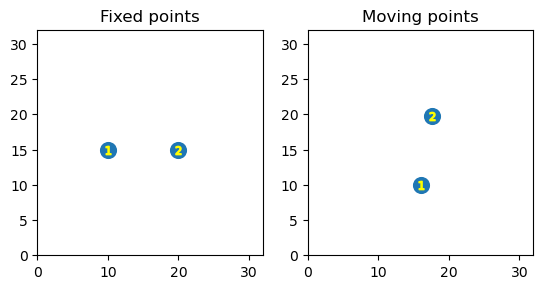

In [3]:
print("Image size: ", image_size)
print(
    f"Rotation angle: {rotation_angle} radians (about {np.rad2deg(rotation_angle):.1f} degrees)"
)
print("Fixed points: ", fixed_points)
print("Moving points: ", moving_points)

fig = plt.figure()
ax1, ax2 = fig.subplots(1, 2)
show_points(ax1, image_size, fixed_points, "Fixed points")
show_points(ax2, image_size, moving_points, "Moving points")

Create a fixed and a moving image. Let them have a black (zero-initialized) background. Make the pixels that correspond (approximately) with the points of the fixed and moving point sets white (value 1).

In [4]:
def create_image(image_size):
    PixelType = itk.SS
    ImageType = itk.Image[PixelType, len(image_size)]
    image = ImageType.New(regions=image_size)
    image.AllocateInitialized()
    return image


fixed_image = create_image(image_size)
moving_image = create_image(image_size)

for point in fixed_points:
    fixed_image.SetPixel((round(point[0]), round(point[1])), 1)
for point in moving_points:
    moving_image.SetPixel((round(point[0]), round(point[1])), 1)

Show the fixed and moving image

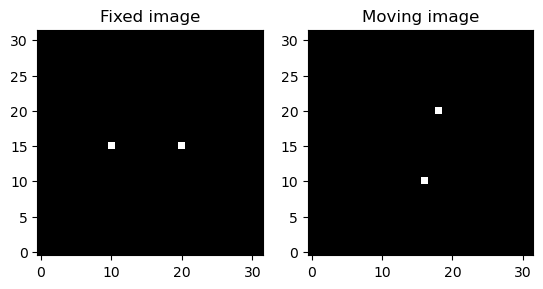

In [5]:
fig = plt.figure()
ax1, ax2 = fig.subplots(1, 2)
show_image(ax1, fixed_image, "Fixed image")
show_image(ax2, moving_image, "Moving image")
plt.show()

So now we have finished creating the synthetic example data. First try to just register the images:

Resulting transformation (rotation, translation X, translation Y):  [ 0.15593503 -1.99956239  4.30013125]


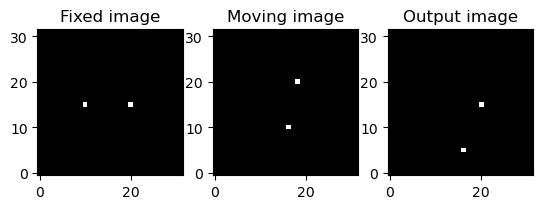

In [6]:
parameter_object = itk.ParameterObject.New()
parameter_object.SetParameterMap(
    {
        "ResampleInterpolator": ("FinalNearestNeighborInterpolator",),
        "ImageSampler": ("Full",),
        "AutomaticScalesEstimation": ("true",),
        "AutomaticTransformInitialization": ("true",),
        "MaximumNumberOfIterations": ("100",),
        "Metric": ("AdvancedNormalizedCorrelation",),
        "Optimizer": ("AdaptiveStochasticGradientDescent",),
        "Registration": ("MultiResolutionRegistration",),
        "Transform": ("EulerTransform",),
    }
)

registration = itk.ElastixRegistrationMethod.New(
    fixed_image=fixed_image,
    moving_image=moving_image,
    parameter_object=parameter_object,
)
registration.Update()

result_transform = registration.GetNthTransform(0)
print(
    "Resulting transformation (rotation, translation X, translation Y): ",
    itk.array_view_from_vnl_vector(result_transform.GetParameters()),
)

show_images_of_registration(registration)

You may have observed that the registration has gone wrong! The output image does not look like the fixed image. And the resulting transformation is not at all what you would expect.

So now we will try to rerun the registration, but now we specify the corresponding points and we include a point-to-point metric:

Resulting transformation (rotation, translation X, translation Y):  [ 1.39805218  0.920003   -0.08029669]
Transformed points:  [(15.967186769703394, 9.915617789383415), (17.68604973535247, 19.766785745789402)]
Moving points:  ((15.965646872587014, 9.917334477168998), (17.665318301589423, 19.7718317770536))



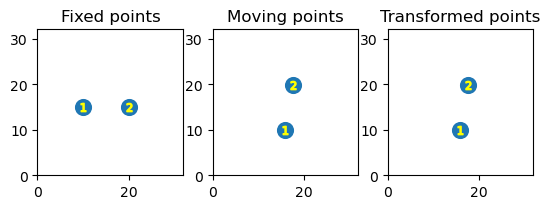

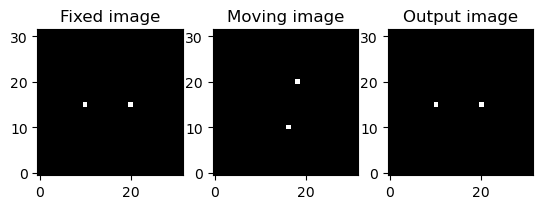

In [7]:
parameter_object.SetParameter(
    "Registration",
    ("MultiMetricMultiResolutionRegistration"),
)
parameter_object.SetParameter(
    "Metric",
    ("AdvancedNormalizedCorrelation", "CorrespondingPointsEuclideanDistanceMetric"),
)

fixed_point_set = make_point_set(dimension, fixed_points)
moving_point_set = make_point_set(dimension, moving_points)

registration = itk.ElastixRegistrationMethod.New(
    fixed_image=fixed_image,
    moving_image=moving_image,
    parameter_object=parameter_object,
    fixed_points=fixed_point_set.GetPoints(),
    moving_points=moving_point_set.GetPoints(),
)
registration.Update()

result_transform = registration.GetNthTransform(0)
print(
    "Resulting transformation (rotation, translation X, translation Y): ",
    itk.array_view_from_vnl_vector(result_transform.GetParameters()),
)

transformed_points = []

for point in fixed_points:
    transformed_point = result_transform.TransformPoint(point)
    transformed_points.append(point_to_tuple(transformed_point))

print("Transformed points: ", transformed_points)
print("Moving points: ", moving_points)
print()
fig = plt.figure()
ax1, ax2, ax3 = fig.subplots(1, 3)
show_points(ax1, image_size, fixed_points, "Fixed points")
show_points(ax2, image_size, moving_points, "Moving points")
show_points(ax3, image_size, transformed_points, "Transformed points")
show_images_of_registration(registration)

That looks more like it! The resulting transformation has a rotation close to the initially applied rotation, and the translation is less than a pixel. The transformed points look very much like the moving points, and the output image looks like the fixed image. So in this case it appears very helpful to add corresponding points to the image registation. &#x1F600;

Note that the very same registration may be performed using the `elastix_registration_method` function, instead of an `ElastixRegistrationMethod` object, as follows:

In [8]:
result_image, result_transform_parameter_object = itk.elastix_registration_method(
    fixed_image=fixed_image,
    moving_image=moving_image,
    parameter_object=parameter_object,
    fixed_points=fixed_point_set.GetPoints(),
    moving_points=moving_point_set.GetPoints(),
)

Which produces a result image that is the same as the previously shown output image, and a parameter object that represents the same transformation: 

ParameterObject (0000025D3D80DE60)
  RTTI typeinfo:   class elastix::ParameterObject
  Reference Count: 1
  Modified Time: 32956
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 15.5 15.5)
  (CompressResultImage "false")
  (DefaultPixelValue)
  (Direction 1 0 0 1)
  (FixedImageDimension 2)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0)
  (InitialTransformParameterFileName "NoInitialTransform")
  (MovingImageDimension 2)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 3)
  (Origin 0 0)
  (ResampleInterpolator "FinalNearestNeighborInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "mhd")
  (ResultImagePixelType "short")
  (Size 32 32)
  (Spacing 1 1)
  (Transform "EulerTransform")
  (TransformParameters 1.39805 0.920003 -0.0802967)
  (UseDirectionCosines "true")



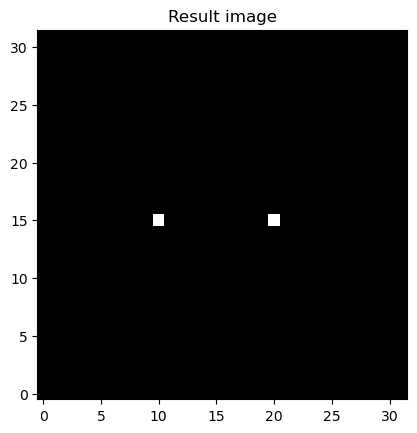

In [9]:
print(result_transform_parameter_object)
fig = plt.figure()
ax = fig.subplots(1, 1)
show_image(ax, result_image, "Result image")